<a href="https://colab.research.google.com/github/fabioachacon/Machine-Deep-Learning/blob/master/GAN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from keras.layers.normalization import BatchNormalization
from keras.engine.input_layer import Input
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [0]:
path_to_data = '/content/drive/My Drive/minifaces'

In [0]:
def load_samples(path_to_data):
    samples = np.zeros(shape=(len(os.listdir(path_to_data)), 3, 50, 50), dtype=np.float32)
    for i, file in enumerate(os.listdir(path_to_data)):
        img_path = os.path.join(path_to_data, file)
        img = cv2.imread(img_path)
        img = img.reshape((3, 50, 50))
        img = (img - 128.0) / 128.0
        samples[i] = img
    return samples  

In [0]:
X_train = load_samples(path_to_data)

In [0]:
X_train = X_train.reshape((X_train.shape[0], 50, 50, 3))

In [0]:
def generator_model():
    generator = Sequential([Dense(units=4 * 4 * 512, input_shape=(100,)),
                            Reshape((4, 4, 512)),
                            Conv2DTranspose(256, (4, 4), activation='relu', strides=2, input_shape=(4, 4, 512)),
                            BatchNormalization(),
                            Conv2DTranspose(128, (3, 3), activation='relu', strides=2),
                            Conv2DTranspose(64, (3, 3), activation='relu', strides=2),
                            Conv2DTranspose(32, (4, 4), activation='relu'),
                            Conv2DTranspose(3, (5, 5), activation='tanh')])
    
    input = Input(shape=(100,))
    generated_image = generator(input)
    return Model(input, generated_image)

g = generator_model()
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 50, 50, 3)         3329859   
Total params: 3,329,859
Trainable params: 3,329,347
Non-trainable params: 512
_________________________________________________________________


In [0]:
def discriminator_model():
    filters = 32
    discriminator = Sequential([Conv2D(filters, (2, 2), strides=2, input_shape=(50, 50, 3)),
                                LeakyReLU(0.2),
                                Conv2D(filters * 2, (2, 2), strides=2),
                                LeakyReLU(0.2),
                                BatchNormalization(),
                                Conv2D(filters * 4, (2, 2), strides=2),
                                BatchNormalization(),
                                Conv2D(filters * 8, (4, 4), strides=2),
                                LeakyReLU(0.2),
                                Flatten(),
                                Dropout(0.3),
                                Dense(1, activation='sigmoid')])
    
    input_image = Input(shape=(50, 50, 3))
    validity = discriminator(input_image)

    return Model(input_image, validity)
                               
d = discriminator_model()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 1)                 567905    
Total params: 567,905
Trainable params: 567,521
Non-trainable params: 384
_________________________________________________________________


In [0]:
optimizer = Adam(1.5e-4, 0.5)
discriminator = discriminator_model()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
generator = generator_model()

random_input = Input(shape=(100,))
generated_image = generator(random_input)

discriminator.trainable = False

validity = discriminator(generated_image)
combined = Model(inputs=random_input, outputs=validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])

In [0]:
def plot_generated_images(epoch=1, generator=None, examples=20, dim=(10,10), figsize=(15, 15)):
    noise = np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = ((generated_images + 1) * 255 / 2).astype(np.int32)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Epoch 1


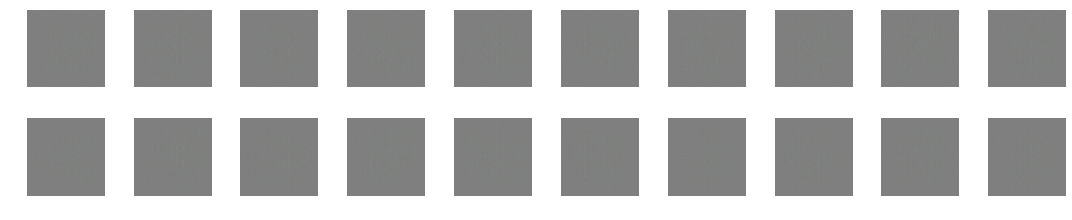

  0%|          | 0/128 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  1%|          | 1/128 [00:03<06:54,  3.26s/it]/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  1%|          | 1/128 [00:00<00:14,  8.87it/s]

Epoch 2


  1%|          | 1/128 [00:00<00:13,  9.34it/s]

Epoch 3


  1%|          | 1/128 [00:00<00:13,  9.57it/s]

Epoch 4


100%|██████████| 128/128 [00:13<00:00,  9.13it/s]


Epoch 5


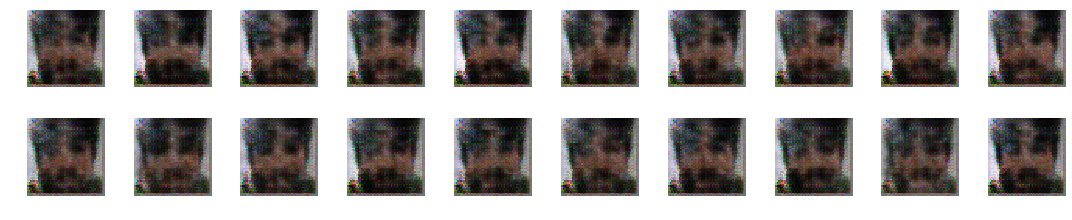

  1%|          | 1/128 [00:00<00:13,  9.28it/s]

Epoch 6


  1%|          | 1/128 [00:00<00:13,  9.38it/s]

Epoch 7


  1%|          | 1/128 [00:00<00:13,  9.39it/s]

Epoch 8


  1%|          | 1/128 [00:00<00:13,  9.15it/s]

Epoch 9


100%|██████████| 128/128 [00:14<00:00,  9.15it/s]


Epoch 10


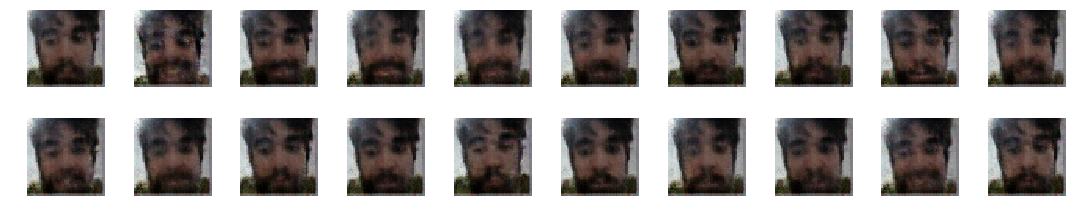

  1%|          | 1/128 [00:00<00:13,  9.43it/s]

Epoch 11


  1%|          | 1/128 [00:00<00:13,  9.25it/s]

Epoch 12


  1%|          | 1/128 [00:00<00:14,  8.97it/s]

Epoch 13


  1%|          | 1/128 [00:00<00:13,  9.27it/s]

Epoch 14


100%|██████████| 128/128 [00:14<00:00,  9.08it/s]


Epoch 15


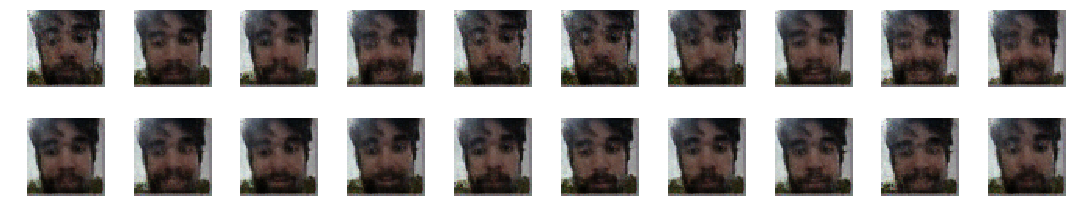

  1%|          | 1/128 [00:00<00:14,  8.96it/s]

Epoch 16


  1%|          | 1/128 [00:00<00:14,  8.96it/s]

Epoch 17


  1%|          | 1/128 [00:00<00:13,  9.36it/s]

Epoch 18


  1%|          | 1/128 [00:00<00:13,  9.35it/s]

Epoch 19


100%|██████████| 128/128 [00:14<00:00,  9.07it/s]


Epoch 20


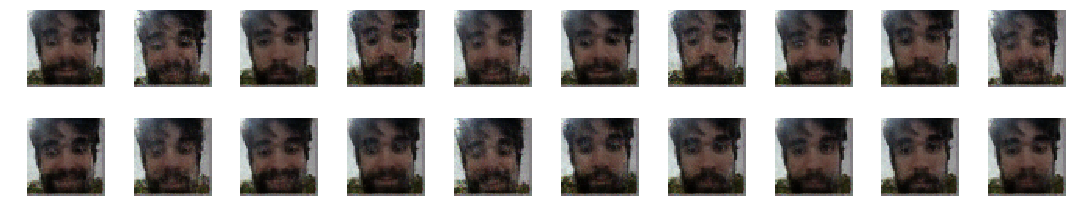

  1%|          | 1/128 [00:00<00:13,  9.30it/s]

Epoch 21


  1%|          | 1/128 [00:00<00:13,  9.43it/s]

Epoch 22


  1%|          | 1/128 [00:00<00:13,  9.46it/s]

Epoch 23


  1%|          | 1/128 [00:00<00:13,  9.46it/s]

Epoch 24


100%|██████████| 128/128 [00:14<00:00,  9.16it/s]


Epoch 25


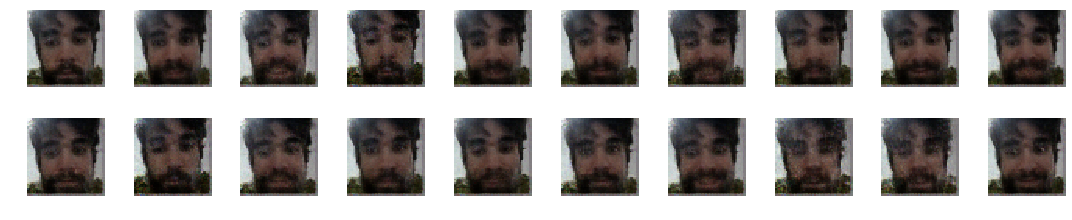

  1%|          | 1/128 [00:00<00:13,  9.29it/s]

Epoch 26


  1%|          | 1/128 [00:00<00:13,  9.16it/s]

Epoch 27


  1%|          | 1/128 [00:00<00:13,  9.16it/s]

Epoch 28


  1%|          | 1/128 [00:00<00:13,  9.37it/s]

Epoch 29


100%|██████████| 128/128 [00:14<00:00,  9.12it/s]


Epoch 30


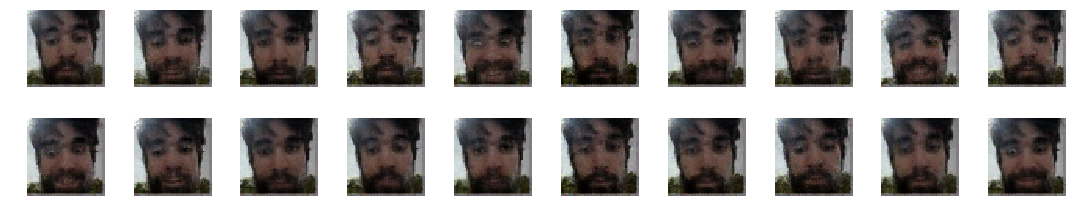

  1%|          | 1/128 [00:00<00:13,  9.26it/s]

Epoch 31


  1%|          | 1/128 [00:00<00:13,  9.23it/s]

Epoch 32


  1%|          | 1/128 [00:00<00:13,  9.43it/s]

Epoch 33


  1%|          | 1/128 [00:00<00:13,  9.17it/s]

Epoch 34


100%|██████████| 128/128 [00:13<00:00,  9.15it/s]


Epoch 35


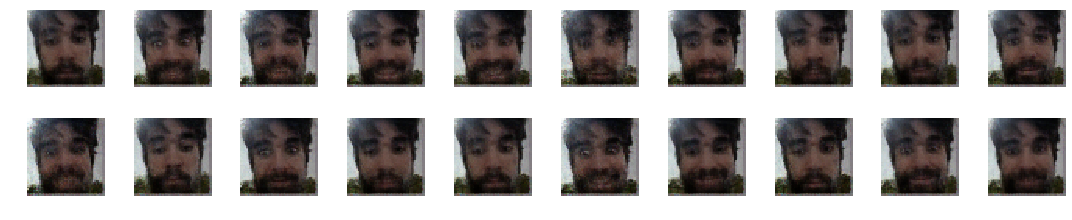

  1%|          | 1/128 [00:00<00:13,  9.57it/s]

Epoch 36


  1%|          | 1/128 [00:00<00:13,  9.26it/s]

Epoch 37


  1%|          | 1/128 [00:00<00:13,  9.36it/s]

Epoch 38


  1%|          | 1/128 [00:00<00:13,  9.10it/s]

Epoch 39


100%|██████████| 128/128 [00:14<00:00,  9.15it/s]


Epoch 40


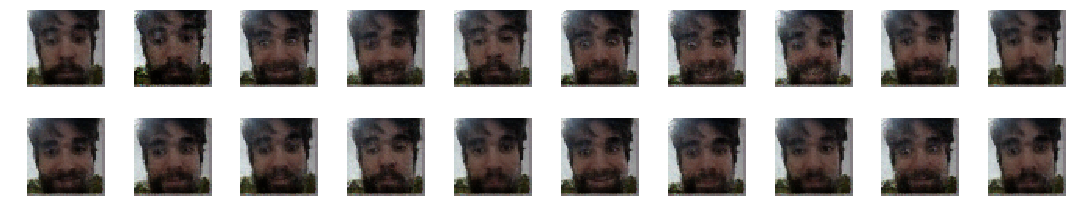

100%|██████████| 128/128 [00:13<00:00,  9.22it/s]


In [0]:
def train(epochs=1, batch_size=128):
    
    y_real = np.ones((batch_size, 1)) * 0.9
    y_fake = np.zeros((batch_size, 1))
    
    for epoch in range(1, epochs+1):
        print('Epoch %d' %epoch)
        if epoch == 1 or epoch % 5 == 0:
          plot_generated_images(epoch, generator)
        for _ in tqdm(range(batch_size)):
            # Generates fake images
            noise_input = np.random.normal(0, 1, (batch_size, 100))
            x_fake = generator.predict(noise_input)
            
            # Takes random batchs of real data
            n_samples = np.random.randint(low=0, high=X_train.shape[0], size=batch_size)
            x_real = X_train[n_samples]
            
            # Train the discriminator on real and fake data
            discriminator_real = discriminator.train_on_batch(x_real, y_real)
            discriminator_fake = discriminator.train_on_batch(x_fake, y_fake)
            discriminator_metric = 0.5 * np.add(discriminator_real, discriminator_fake)
            
            # Train generator on calculated loss
            generator_metric = combined.train_on_batch(noise_input, y_real)
train(epochs=40)

In [0]:
from keras.models import load_model

In [0]:
generator.save(os.path.join(path_to_data, "face_generator.h5"))

In [0]:
model = load_model(os.path.join('/content/drive/My Drive/models', "my_face_generator.h5"))

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
